# English-to-Spanish Translation with Custom Transformer from scratch

In [ ]:
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time
from pathlib import Path
import pandas as pd
%matplotlib notebook

## The Data

In [2]:
path = Path("spa.txt")

In [3]:
# Converts the unicode file to ascii
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn')

In [4]:
def preprocess_sentence(s):
    s = unicode_to_ascii(s.lower().strip())
    
    #Add space before any punctuation
    s = re.sub(r"([?.!,¿])", r" \1 ", s)
    
    #Remove several spaces with a single space
    s = re.sub(r'[" "]+', " ", s)
       
    return "<start> " + s.strip() + " <end>"

In [5]:
def parse_file(path, num_examples):
    lines = io.open(path, encoding='UTF-8').read().strip().split('\n')
    
    word_pairs = [[preprocess_sentence(s) for s in line.split('\t')[:2]] for line in lines[:num_examples]]
    
    return zip(*word_pairs)

In [6]:
def tokenize(sentences):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    tokenizer.fit_on_texts(sentences)
    
    tensor = tokenizer.texts_to_sequences(sentences)
    
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')
    
    return tensor, tokenizer

In [7]:
def max_length(tensor):
    return max(len(t) for t in tensor)

In [8]:
def load_data(path, num_examples=None):
    inp_sentences, targ_sentences = parse_file(path, num_examples)
    
    inp_tensors, inp_lang_tokenizer = tokenize(inp_sentences)
    targ_tensors, targ_lang_tokenizer = tokenize(targ_sentences)
    
    return inp_tensors, targ_tensors, inp_lang_tokenizer, targ_lang_tokenizer

In [9]:
num_examples = 30000
eng, spa = parse_file(path, num_examples)
print(eng[-1])
print(spa[-1])

<start> nice talking with you . <end>
<start> fue agradable hablar con usted . <end>


In [70]:
# Try experimenting with the size of that dataset
num_examples = 30000
input_tensor, target_tensor, inp_lang, targ_lang = load_data(path, num_examples)

# Calculate max_length of the target tensors
max_length_targ, max_length_inp = max_length(target_tensor), max_length(input_tensor)

In [71]:
def convert(lang, tensor):
    for word in tensor:
        if word != 0:
            print(f"{word} -----> {lang.index_word[word]}")

In [72]:
convert(inp_lang, input_tensor[0])

1 -----> <start>
29 -----> go
3 -----> .
2 -----> <end>


In [73]:
convert(targ_lang, target_tensor[0])

1 -----> <start>
143 -----> ve
3 -----> .
2 -----> <end>


In [74]:
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

In [75]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
STEPS_PER_EPOCH = len(input_tensor_train) // BATCH_SIZE
vocab_inp_size = len(inp_lang.word_index) + 1
vocab_targ_size = len(targ_lang.word_index) + 1

In [76]:
train_data = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
train_data = train_data.batch(BATCH_SIZE)

In [78]:
example_input_batch, example_target_batch = next(iter(train_data))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 11]), TensorShape([64, 16]))

## Masking

In [18]:
def create_padding_mask(seq):
    mask = tf.cast(tf.math.equal(seq, 0), tf.float32)
    
    return mask[:, tf.newaxis, tf.newaxis, :] #(batch_size, 1, 1, seq_len)

In [19]:
x = tf.constant([[7, 6, 0, 0, 1], [1, 2, 3, 0, 0], [0, 0, 0, 4, 5]])
create_padding_mask(x)

<tf.Tensor: id=27, shape=(3, 1, 1, 5), dtype=float32, numpy=
array([[[[0., 0., 1., 1., 0.]]],


       [[[0., 0., 0., 1., 1.]]],


       [[[1., 1., 1., 0., 0.]]]], dtype=float32)>

In [20]:
#Have ones in upper triangular part (zeroes on the lower triangle + diagonal)
#Note: The ones are placed on the positions which NEED to be masked
def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask

In [21]:
x = tf.random.uniform((1, 5))
temp = create_look_ahead_mask(x.shape[1])
temp

<tf.Tensor: id=42, shape=(5, 5), dtype=float32, numpy=
array([[0., 1., 1., 1., 1.],
       [0., 0., 1., 1., 1.],
       [0., 0., 0., 1., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0.]], dtype=float32)>

## Defining The Transformer Model
- Here, we will create all the components necessary to build our own Transformer model from scratch

In [22]:
class PositionalEncoding(tf.keras.Model):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        
        self.pe = np.zeros((max_len, d_model))
        positions = np.arange(max_len)[:, np.newaxis] #(max_len, 1)
        angle_rads = np.exp(np.arange(0, d_model, 2) *
                            -(np.log(10000) / np.float32(d_model)))
        
        self.pe[:, 0::2] = np.sin(positions * angle_rads) #fill all even indices with sines
        self.pe[:, 1::2] = np.cos(positions * angle_rads) #fill all odd indices with cosines
        
        self.pe = tf.expand_dims(tf.cast(self.pe, tf.float32), 0)
        
    def call(self, x):
        #x is (batch_size, seq_len, d_model)
        seq_len = tf.shape(x)[1]
        
        return x + self.pe[:, :seq_len, :]

In [53]:
sample_pe = PositionalEncoding(256)
sample_inp = tf.random.normal((64, 36, 256))
print(sample_pe(sample_inp).shape)

(64, 36, 256)


In [23]:
def positionwise_feed_forward_network(d_model, d_ff):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(d_ff),
        tf.keras.layers.Dense(d_model)
    ])

In [24]:
def scaled_dot_product_attention(Q, K, V, mask):
    """Calculate the attention weights.
      Q, K, V must have matching leading dimensions.
      K, V must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
      The mask has different shapes depending on its type(padding or look ahead) 
      but it must be broadcastable for addition.

      Args:
        Q: query shape == (..., seq_len_q, depth)
        K: key shape == (..., seq_len_k, depth)
        V: value shape == (..., seq_len_v, depth_v)
        mask: Float tensor with shape broadcastable 
              to (..., seq_len_q, seq_len_k). Defaults to None.

      Returns:
        output, attention_weights
      """ 
    
    matmul_QK = tf.matmul(Q, K, transpose_b=True) #(batch_size, num_heads, seq_len_q, seq_len_k)
    
    dk = tf.shape(K)[-1]
    scaled_attention_logits = matmul_QK / tf.math.sqrt(tf.cast(dk, tf.float32)) #(batch_size, num_heads, seq_len_q, seq_len_k)
    
    if mask is not None:
        scaled_attention_logits += (mask * -1e-9)
    
    #normalize last axis (seq_len_k) so that weights add up to 1
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
    
    attention_out = tf.matmul(attention_weights, V) #(batch_size, num_heads, seq_len_q, depth_v)
    
    return attention_out, attention_weights
    

In [25]:
class MultiHeadAttention(tf.keras.Model):
    def __init__(self, d_model, n_heads):
        super(MultiHeadAttention, self).__init__()
        self.d_model = d_model
        self.num_heads = n_heads
        
        assert d_model % n_heads == 0
        
        self.depth = self.d_model // self.num_heads
        
        self.W_Q = tf.keras.layers.Dense(d_model)
        self.W_K = tf.keras.layers.Dense(d_model)
        self.W_V = tf.keras.layers.Dense(d_model)
        
        self.dense = tf.keras.layers.Dense(d_model)
        
    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3]) #(batch_size, num_heads, seq_len_x, depth)
    
    def call(self, query, key, value, mask):
        batch_size = tf.shape(query)[0]
        
        queries = self.W_Q(query) #(batch_size, seq_len, d_model)
        keys = self.W_K(key) #(batch_size, seq_len, d_model)
        values = self.W_V(value) #(batch_size, seq_len, d_model)
        
        queries = self.split_heads(queries, batch_size) #(batch_size, num_heads, seq_len_q, depth)
        keys = self.split_heads(keys, batch_size) #(batch_size, num_heads, seq_len_k, depth)
        values = self.split_heads(values, batch_size) #(batch_size, num_heads, seq_len_v, depth)
        
        #scaled_attention.shape = (batch_size, num_heads, seq_len_q, depth)
        #attn_weights.shape = (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention, attn_weights = scaled_dot_product_attention(queries, keys, values, mask)
        
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3]) #(batch_size, seq_len_q, dense, num_heads, depth)
        
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model)) #(batch_size, seq_len_q, d_model)
        
        out = self.dense(concat_attention) #(batch_size, seq_len_q, d_model)
        
        return out, attn_weights

In [57]:
sample_mha = MultiHeadAttention(256, 8)
sample_inp = tf.random.normal((64, 40, 256))
sample_mha_out, _ = sample_mha(sample_inp, sample_inp, sample_inp, None)
print(sample_mha_out.shape)

(64, 40, 256)


#### Encoder Layer

One encoder layer contains the following:
- One MultiHeadAttention Layer
- Followed up a residual layer normalization layer
- A positionwise feedforward layer
- A final residual layer normalization layer

In [26]:
class EncoderLayer(tf.keras.Model):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()
        
        self.mha = MultiHeadAttention(d_model, n_heads)
        self.ffn = positionwise_feed_forward_network(d_model, d_ff)
        
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        
        self.dropout1 = tf.keras.layers.Dropout(rate=dropout)
        self.dropout2 = tf.keras.layers.Dropout(rate=dropout)
        
    def call(self, x, training, mask):
        attn_output, _ = self.mha(x, x, x, mask)
        attn_output = self.dropout1(attn_output, training=training) #attn_output is (batch_size, inp_seq_len, d_model)
        
        x = self.layernorm1(x + attn_output)
        
        ffn_out = self.ffn(x)
        ffn_out = self.dropout2(ffn_out, training=training)
        
        x = self.layernorm2(x + ffn_out)
        
        return x

In [59]:
sample_enc_layer = EncoderLayer(256, 8, 1024, 0.1)
sample_enc_inp = tf.random.normal((64, 50, 256))
sample_enc_out = sample_enc_layer(sample_enc_inp, False, None)
sample_enc_out.shape

TensorShape([64, 50, 256])

#### Decoder Layer

One decoder layer contains the following:
- One Self-MultiHeadAttention Layer
- Followed up a residual layer normalization layer
- One Encoder-Decoder MultiHeadAttention layer
- Another residual layer-norm layer
- A positionwise feedforward layer
- A final residual layer normalization layer

In [27]:
class DecoderLayer(tf.keras.Model):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()
        
        self.mha1 = MultiHeadAttention(d_model, n_heads)
        self.mha2 = MultiHeadAttention(d_model, n_heads)
        self.ffn = positionwise_feed_forward_network(d_model, d_ff)
        
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        
        self.dropout1 = tf.keras.layers.Dropout(rate=dropout)
        self.dropout2 = tf.keras.layers.Dropout(rate=dropout)
        self.dropout3 = tf.keras.layers.Dropout(rate=dropout)
        
    def call(self, x, enc_out, training, padding_mask, look_ahead_mask):
        #First is the self-attention layer on the target sequence
        attn_output1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)
        attn_output1 = self.dropout1(attn_output1, training=training) #attn_output1 is (batch_size, targ_seq_len, d_model)
        out1 = self.layernorm1(x + attn_output1)
        
        #Second is the Encoder-Decoder Attention layer with out1 as the queries and the encoder's output as the keys and the values
        attn_output2, attn_weights_block2 = self.mha2(out1, enc_out, enc_out, padding_mask)
        attn_output2 = self.dropout2(attn_output2, training=training)
        out2 = self.layernorm2(out1 + attn_output2)
        
        #Third, we have a positionwise feedforward layer
        ffn_out = self.ffn(out2)
        ffn_out = self.dropout3(ffn_out, training=training)
        
        #Finally, a residual layer normalization layer
        final_out = self.layernorm3(out2 + ffn_out)
        
        return final_out, attn_weights_block1, attn_weights_block2

In [61]:
sample_dec_layer = DecoderLayer(256, 8, 1024, 0.1)
sample_dec_inp = tf.random.normal((64, 40, 256))
sample_dec_out, _, _ = sample_dec_layer(sample_dec_inp, sample_enc_out, False, None, None)
sample_dec_out.shape

TensorShape([64, 40, 256])

#### Encoder

An Encoder is the following:
- An Embedding Layer
- PositionalEncoding Layer
- N EncoderLayers

In [28]:
class Encoder(tf.keras.Model):
    def __init__(self, inp_vocab_size, n_layers, n_heads, d_model, d_ff, dropout):
        super(Encoder, self).__init__()
        
        self.embedding = tf.keras.layers.Embedding(inp_vocab_size, d_model)
        self.pe = PositionalEncoding(d_model)
                
        self.encoder_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout)
                               for _ in range(n_layers)]
        
        self.dropout_layer = tf.keras.layers.Dropout(rate=dropout)

        
    def call(self, x, training, padding_mask):
        x = self.dropout_layer(self.pe(self.embedding(x)), training=training)
        
        for enc_layer in self.encoder_layers:
            x = enc_layer(x, training, padding_mask)
        
        return x #x is (batch_size, input_seq_len, d_model)

#### Decoder

A Decoder is the following:
- An embedding layer
- PositionalEncoding Layer
- N DecoderLayers

In [29]:
class Decoder(tf.keras.Model):
    def __init__(self, targ_vocab_size, n_layers, n_heads, d_model, d_ff, dropout):
        super(Decoder, self).__init__()
        
        self.embedding=tf.keras.layers.Embedding(targ_vocab_size, d_model)
        self.pe = PositionalEncoding(d_model)
        
        self.decoder_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout) 
                               for _ in range(n_layers)]
        
        self.dropout_layer = tf.keras.layers.Dropout(rate=dropout)
        
    def call(self, x, enc_out, training, padding_mask, look_ahead_mask):
        x = self.pe(self.embedding(x))
        x = self.dropout_layer(x, training=training)
        
        attn_weights = {}
        
        for i, dec_layer in enumerate(self.decoder_layers):
            x, block1, block2 = dec_layer(x, enc_out, training, padding_mask, look_ahead_mask)
            
            attn_weights[f"decoder_layer{i+1}_block1"] = block1
            attn_weights[f"decoder_layer{i+1}_block2"] = block2
            
        #x is (batch_size, targ_seq_len, d_model)
        return x, attn_weights 

#### Transformer

The Transformer combines the following layers:
- Encoder
- Decoder
- Final Dense layer with softmax

In [34]:
class Transformer(tf.keras.Model):
    def __init__(self, inp_vocab_size, targ_vocab_size, n_layers=6, n_heads=8, d_model=512, d_ff=2048, dropout=0.1):
        super(Transformer, self).__init__()
        
        self.encoder = Encoder(inp_vocab_size, n_layers, n_heads, d_model, d_ff, dropout)
        self.decoder = Decoder(targ_vocab_size, n_layers, n_heads, d_model, d_ff, dropout)
        
        self.final_layer = tf.keras.layers.Dense(targ_vocab_size)
        
    def call(self, inp, targ, training, inp_padding_mask, 
             look_ahead_mask, targ_padding_mask):
        
        encoded = self.encoder(inp, training, inp_padding_mask)
        decoded, attn_weights = self.decoder(targ, encoded, training, targ_padding_mask, look_ahead_mask)
        
        final_output = self.final_layer(decoded)
        
        return final_output, attn_weights

In [35]:
sample_transformer = Transformer(inp_vocab_size=1000, targ_vocab_size=1000, n_layers=4,
                                 n_heads=8, d_model=256, d_ff=256, dropout=0.2)

In [36]:
sample_inp = tf.random.uniform((64, 38), dtype=tf.int64, minval=0, maxval=200)
sample_targ = tf.random.uniform((64, 36), dtype=tf.int64, minval=0, maxval=200)

In [37]:
sample_out, _ = sample_transformer(sample_inp, sample_targ, training=False, 
                                   inp_padding_mask=None, look_ahead_mask=None,
                                   targ_padding_mask=None)

In [38]:
sample_out.shape

TensorShape([64, 36, 1000])

In [39]:
sample_transformer.summary()

Model: "transformer_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_1 (Encoder)          multiple                  1839104   
_________________________________________________________________
decoder_1 (Decoder)          multiple                  2893824   
_________________________________________________________________
dense_129 (Dense)            multiple                  257000    
Total params: 4,989,928
Trainable params: 4,989,928
Non-trainable params: 0
_________________________________________________________________


#### Custom Learning Rate Scheduler

In [123]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()
        self.d_model = tf.cast(d_model, tf.float32)
        self.warmup_steps = warmup_steps
        
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** (-1.5))
        
        return tf.math.rsqrt(self.d_model) * tf.minimum(arg1, arg2)

<IPython.core.display.Javascript object>


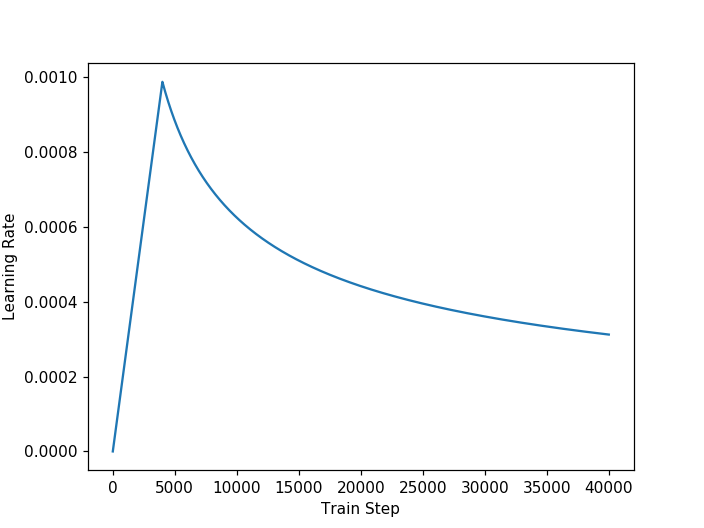

Text(0.5, 0, 'Train Step')

In [124]:
temp_learning_rate_schedule = CustomSchedule(256)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

We can see that our custom learning rate scheduler linearly warms up for a few epochs and then decreases the learning according to a `sqrt` function.

In [ ]:
###

#### Define optimizer and loss function

In [150]:
num_layers = 4
d_model = 256
d_ff = 256
n_heads = 8
dropout_rate = 0.1

In [151]:
optimizer = tf.keras.optimizers.Adam(CustomSchedule(d_model), beta_1=0.9, beta_2=0.98, epsilon=1e-9)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

In [152]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    
    loss = loss_ * mask
    return tf.reduce_mean(loss)

In [153]:
transformer = Transformer(vocab_inp_size, vocab_targ_size, n_layers=num_layers, n_heads=n_heads,
                          d_model=d_model, d_ff=d_ff, dropout=dropout_rate)

In [154]:
def create_masks(inp, targ):
    
    inp_pad_mask = create_padding_mask(inp)
    
    dec_pad_mask = create_padding_mask(inp)
    
    targ_look_ahead_mask = create_look_ahead_mask(tf.shape(targ)[1])
    targ_padding_mask = create_padding_mask(targ)
    combined_mask = tf.maximum(targ_padding_mask, targ_look_ahead_mask)
    
    return inp_pad_mask, combined_mask, dec_pad_mask

In [155]:
#create_masks(sample_inp, sample_targ)

In [156]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# # if a checkpoint exists, restore the latest checkpoint.
# if ckpt_manager.latest_checkpoint:
#   ckpt.restore(ckpt_manager.latest_checkpoint)
#   print ('Latest checkpoint restored!!')

In [157]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    name='train_accuracy')

In [158]:
EPOCHS = 30

#### Define custom training loops in Tensorflow 2

In [159]:
@tf.function
def train_step(inp, targ):
    targ_inp = targ[:, :-1]
    targ_real = targ[:, 1:]

    inp_padding_mask, look_ahead_mask, targ_padding_mask = create_masks(inp, targ_inp)
    
    with tf.GradientTape() as tape:
        preds, _ = transformer(inp, targ_inp, True, 
                               inp_padding_mask,
                               look_ahead_mask,
                               targ_padding_mask)
        
        loss = loss_function(targ_real, preds)
    
    gradients = tape.gradient(loss, transformer.trainable_variables)
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
    
    train_loss(loss)
    train_accuracy(targ_real, preds)
        

In [160]:
def train(data, epochs=20):
    for epoch in range(epochs):
        start = time.time()
        
        train_loss.reset_states()
        train_accuracy.reset_states()
        
        for i, (inp, targ) in enumerate(data):
            train_step(inp, targ)
            
            if (i % 100) == 0:
                print(f"Epoch: {epoch+1} Batch: {i} Loss: {train_loss.result()} Accuracy {train_accuracy.result()}")
        
        if (epoch + 1) % 2 == 0:
            ckpt_save_path = ckpt_manager.save()
            print(f"Saving checkpoint for epoch {epoch+1} at {ckpt_save_path}")
            
        print ('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1, 
                                                train_loss.result(), 
                                                train_accuracy.result()))
        
        print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))
            

In [161]:
train(train_data, EPOCHS)

Epoch: 1 Batch: 0 Loss: 3.2545416355133057 Accuracy 0.0
Epoch: 1 Batch: 100 Loss: 3.3055946826934814 Accuracy 0.044884487986564636
Epoch: 1 Batch: 200 Loss: 3.117581844329834 Accuracy 0.05571102723479271
Epoch: 1 Batch: 300 Loss: 2.905153274536133 Accuracy 0.05935077369213104
Epoch 1 Loss 2.7483 Accuracy 0.0614
Time taken for 1 epoch: 85.8241217136383 secs

Epoch: 2 Batch: 0 Loss: 1.9612849950790405 Accuracy 0.08541666716337204
Epoch: 2 Batch: 100 Loss: 1.8957637548446655 Accuracy 0.09647276997566223
Epoch: 2 Batch: 200 Loss: 1.8124017715454102 Accuracy 0.11388370394706726
Epoch: 2 Batch: 300 Loss: 1.7435333728790283 Accuracy 0.1252526342868805
Saving checkpoint for epoch 2 at ./checkpoints/train\ckpt-1
Epoch 2 Loss 1.7008 Accuracy 0.1308
Time taken for 1 epoch: 72.60078859329224 secs

Epoch: 3 Batch: 0 Loss: 1.448118805885315 Accuracy 0.15729166567325592
Epoch: 3 Batch: 100 Loss: 1.4425849914550781 Accuracy 0.1556105613708496
Epoch: 3 Batch: 200 Loss: 1.4027537107467651 Accuracy 0.158

Epoch: 21 Batch: 100 Loss: 0.1866970807313919 Accuracy 0.34549298882484436
Epoch: 21 Batch: 200 Loss: 0.2001620978116989 Accuracy 0.3444910943508148
Epoch: 21 Batch: 300 Loss: 0.2126070261001587 Accuracy 0.3438365161418915
Epoch 21 Loss 0.2192 Accuracy 0.3432
Time taken for 1 epoch: 75.97014045715332 secs

Epoch: 22 Batch: 0 Loss: 0.15468929708003998 Accuracy 0.3489583432674408
Epoch: 22 Batch: 100 Loss: 0.18346798419952393 Accuracy 0.34667903184890747
Epoch: 22 Batch: 200 Loss: 0.1963718831539154 Accuracy 0.345278799533844
Epoch: 22 Batch: 300 Loss: 0.20281367003917694 Accuracy 0.34472590684890747
Saving checkpoint for epoch 22 at ./checkpoints/train\ckpt-11
Epoch 22 Loss 0.2085 Accuracy 0.3446
Time taken for 1 epoch: 79.16771054267883 secs

Epoch: 23 Batch: 0 Loss: 0.19175773859024048 Accuracy 0.34062498807907104
Epoch: 23 Batch: 100 Loss: 0.17091073095798492 Accuracy 0.350340336561203
Epoch: 23 Batch: 200 Loss: 0.18136608600616455 Accuracy 0.34790629148483276
Epoch: 23 Batch: 300 Lo

In [162]:
# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

Latest checkpoint restored!!


#### Evaluate our model

In [163]:
def evaluate(sentence):
    sentence = preprocess_sentence(sentence)
    
    inp = [inp_lang.word_index[w] for w in sentence.split(' ')]
    inp = tf.keras.preprocessing.sequence.pad_sequences([inp], maxlen=max_length_inp, padding='post')
    
    enc_inp = tf.convert_to_tensor(inp)
    output = tf.expand_dims([targ_lang.word_index['<start>']], 0)
    
    for i in range(max_length_targ):
        inp_padding_mask, look_ahead_mask, targ_padding_mask = create_masks(enc_inp, output)
        
        preds, attn_weights = transformer(enc_inp, output, False,
                                          inp_padding_mask, look_ahead_mask,
                                          targ_padding_mask)
        
        preds = preds[:, -1:, :] #(1, 1, vocab_targ_size)
        predicted_id = tf.argmax(preds, axis=-1, output_type=tf.int32)
        
        if predicted_id == targ_lang.word_index['<end>']:
            return tf.squeeze(output, axis=0), attn_weights
        
        output = tf.concat([output, predicted_id], axis=-1)
    
    return tf.squeeze(output, axis=0), attn_weights
    
    

In [164]:
def translate(sentence, plot=''):
    result, attn_weights = evaluate(sentence)
    print(result)
    predicted_sentence = ' '.join([targ_lang.index_word[t] for t in result.numpy()])
    
    return predicted_sentence

In [166]:
translate(u'How are you?')

tf.Tensor([  1   3 294 294   3   3   3   3], shape=(8,), dtype=int32)


'<start> . anos anos . . . .'